In [1]:
import os
import sys
import cmocean
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pydap
from pydap.client import open_url

# import maptools
sys.path.insert(0, os.path.expanduser('~/Dropbox/3. Post-Doc/PF-py'))
from maptools import gridplot, bathymetry, axis
from changeCoordinates import wrap_to_360, wrap_to_180
from colorbar_shift import shiftedColorMap 

# Latest forecast models http://nomads.ncep.noaa.gov

# GFS http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25

# CMC http://nomads.ncep.noaa.gov:9090/dods/cmcens/
# (in the ensembles there are the Control model (member 0, c00) and the 20 Perturbed models or members (pXX)

The use of pydap makes retrieving the data from the site really easy in python

In [2]:
url = 'http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs20180528/gfs_0p25_06z'
# create a dataset object
dataset = pydap.client.open_url(url)
 
# print the first 10 values
lat = dataset['lat'][:]
lon = dataset['lon'][:] # from 0-360
print(dataset)

<DatasetType with children 'absvprs', 'no4lftxsfc', 'no5wavh500mb', 'acpcpsfc', 'albdosfc', 'apcpsfc', 'capesfc', 'cape180_0mb', 'cape255_0mb', 'cfrzrsfc', 'cicepsfc', 'cinsfc', 'cin180_0mb', 'cin255_0mb', 'clwmrprs', 'cpofpsfc', 'cpratsfc', 'crainsfc', 'csnowsfc', 'cwatclm', 'cworkclm', 'dlwrfsfc', 'dpt2m', 'dswrfsfc', 'fldcpsfc', 'gfluxsfc', 'gustsfc', 'hgtsfc', 'hgtprs', 'hgt2pv', 'hgtneg2pv', 'hgttop0c', 'hgt0c', 'hgtmwl', 'hgttrop', 'hindexsfc', 'hlcy3000_0m', 'hpblsfc', 'icahtmwl', 'icahttrop', 'icecsfc', 'icsevprs', 'landsfc', 'landnsfc', 'lftxsfc', 'lhtflsfc', 'msletmsl', 'o3mrprs', 'pevprsfc', 'plpl255_0mb', 'potsig995', 'pratesfc', 'preslclb', 'preslclt', 'presmclb', 'presmclt', 'preshclb', 'preshclt', 'pressfc', 'pres80m', 'pres2pv', 'presneg2pv', 'prescclb', 'prescclt', 'presmwl', 'prestrop', 'prmslmsl', 'pwatclm', 'rhprs', 'rh2m', 'rhsg330_1000', 'rhsg440_1000', 'rhsg720_940', 'rhsg440_720', 'rhsig995', 'rh30_0mb', 'rhclm', 'rhtop0c', 'rh0c', 'shtflsfc', 'snodsfc', 'soilw0

In [3]:
print(len(lat))
print(len(lon))
print(lon[:])

721
1440
[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.5925e+02 3.5950e+02 3.5975e+02]


In [4]:
# boundaries of the domain for plotting
# approximate region for Western Atlantic
p_lon = [-110, -50]
p_lat = [5, 45]

# bathymetry data for the domain
elon, elat, ez = bathymetry.bathymetry_etopo(p_lon, p_lat)
eland = ez
eland[eland > 0] = 150.

# decrease resolution of topography map
skip = 1
elon = elon[::skip]
elat = elat[::skip]
ez = ez[::skip,::skip]
eland = eland[::skip,::skip]

In [5]:
# select timestep
time_index = 5

# restrict to plot region
i0 = np.argmin((wrap_to_360(p_lon[0]) - lon) ** 2)
i1 = np.argmin((wrap_to_360(p_lon[1]) - lon) ** 2)
j0 = np.argmin((p_lat[0] - lat) ** 2)
j1 = np.argmin((p_lat[1] - lat) ** 2)
lon = lon[i0:i1]
lat = lat[j0:j1]

# temperature
temp_var = dataset['tmpsfc']
temp_data = temp_var[time_index, j0:j1, i0:i1].data[0] # download only subset
temp_t = np.squeeze(temp_data) - 273 # [K] to [°C]

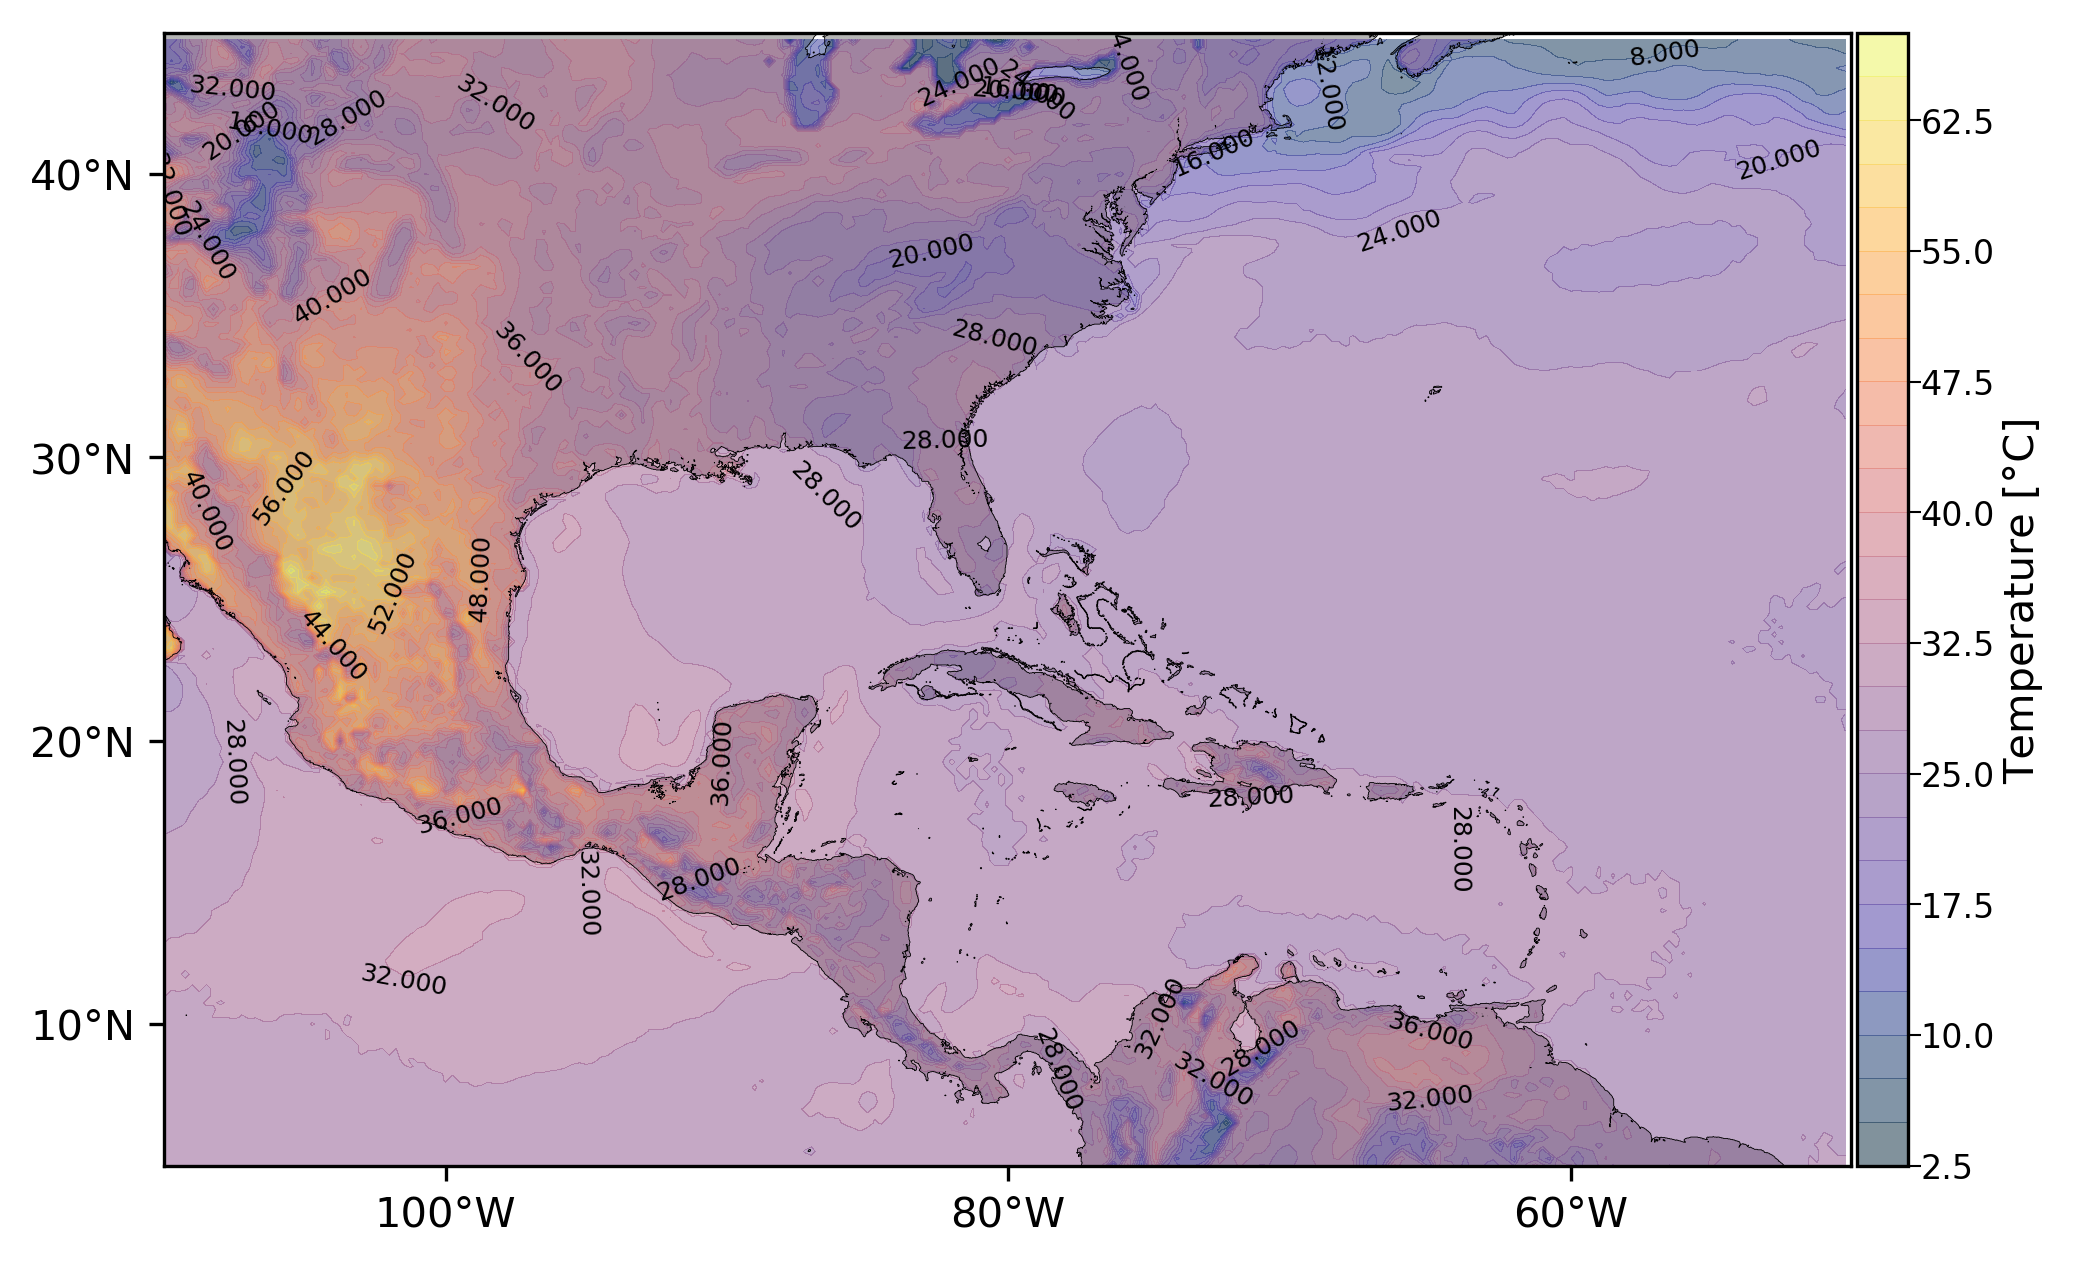

In [10]:
width = 7.5
ratio = (p_lat[1] - p_lat[0]) / (p_lon[1] - p_lon[0])

fig = plt.figure(figsize=(width, width * ratio), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.contour(elon, elat, ez, [0], colors='black', linewidths=0.2)
ax.contourf(elon, elat, eland, np.arange(0, 510, 10), cmap=cm.binary)
axis.format(ax, 20, 10)

# shift the colorbar according to min/max values=
#midpoint = 1 - 5/(np.max(temp_t) - np.min(temp_t))
#thermal = shiftedColorMap(cmocean.cm.thermal, 0, midpoint, 1.0, 'shiftedthermal')
p = ax.contourf(wrap_to_180(lon), lat, temp_t, 25, cmap=cmocean.cm.thermal, zorder=1, alpha=0.5)
cs = ax.contour(wrap_to_180(lon), lat, temp_t, 15, colors='black', linewidths=0)
ax.clabel(cs, fontsize=6)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02)
cb = fig.colorbar(p, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Temperature [°C]', size=10, labelpad=2)